In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/Crop_Data__cleaned.csv')

In [3]:
df.shape

(205688, 25)

In [4]:
df.columns

Index(['State', 'District', 'Lat', 'Long', 'GW_depth_Min', 'GW_depth_Max',
       'Wells_depth_0_to_2', 'Wells_depth_2_to_5', 'Wells_depth_5_to_10',
       'Wells_depth_10_to_20', 'Wells_depth_20_to_40',
       'Wells_depth_40_and_above', 'Precipitation', 'Solar_Radiation',
       'Surface_Pressure', 'Humidity', 'Temp_Max', 'Temp_Min',
       'Dew_Frost_Point', 'Wind_Speed', 'Year', 'Season', 'Crop', 'Area',
       'Production'],
      dtype='object')

In [5]:
crop_net_production = df.groupby('Crop')['Production'].sum().sort_values()
crop_net_production

Crop
Lentil                 3.358000e+03
Cashewnut Processed    8.121000e+03
Blackgram              4.163100e+04
Varagu                 4.969400e+04
Jack Fruit             5.768700e+04
                           ...     
Potato                 3.567839e+08
Wheat                  1.290123e+09
Rice                   1.470305e+09
Sugarcane              5.370029e+09
Coconut                1.289255e+11
Name: Production, Length: 81, dtype: float64

In [6]:
crops_with_zero_production = crop_net_production.loc[crop_net_production == 0].index
crops_with_zero_production

Index([], dtype='object', name='Crop')

In [7]:
# Remove records for crops which have net production as zero
df = df.loc[~df['Crop'].isin(crops_with_zero_production)].reset_index()

## Analysis including 'Other... ' crops

In [8]:
df_crop = pd.get_dummies(df[['Crop', 'Season']].drop_duplicates())

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [10]:
silhouette_scores = []
inertia_scores = []
k_range = range(2, 20)
for k in k_range:
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(df_crop)
    preds = clusterer.predict(df_crop)
    centers = clusterer.cluster_centers_
    inertia_scores.append(clusterer.inertia_)
    silhouette_scores.append(silhouette_score(df_crop, preds))

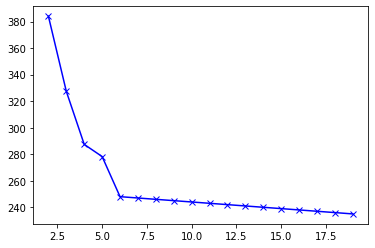

In [11]:
# Inertia vs k
plt.plot(k_range, inertia_scores, 'bx-')

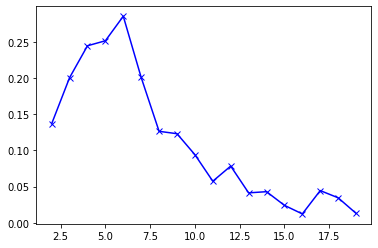

In [12]:
# Plot Silhoutte scores vs k
plt.plot(k_range, silhouette_scores, 'bx-')

Based on domain knowledge, crops are generally season. The season is time in which they are sown and harvested.

From above analysis, it looks like the crop and season in dataset represent six categories. 

In [13]:
df['Season'].nunique()

6

In [14]:
df['Crop'].nunique()

81

In [15]:
df_grouped = df.groupby('Crop')['Season']

In [16]:
def to_only_whole_year(l):
    if 'Whole Year' in l or len(l) == 5:
        return ['Whole Year']
    else:
        return l

# Unique combinations of seasons fbased on crops
df_grouped.unique().apply(lambda l: str(sorted(to_only_whole_year(l)))).unique()

array(["['Whole Year']", "['Kharif', 'Rabi']",
       "['Kharif', 'Rabi', 'Summer']", "['Autumn', 'Kharif', 'Rabi']",
       "['Kharif']", "['Rabi']"], dtype=object)

There are 7 unique combinations of farming seasons when other crops are included.

In [17]:
clusterer_6 = KMeans(n_clusters=6)
clusterer_6.fit(df_crop)

KMeans(n_clusters=6)

In [18]:
df['Crop_Type'] = clusterer_6.predict(pd.get_dummies(df[['Crop', 'Season']]))

<AxesSubplot:xlabel='count', ylabel='Crop'>

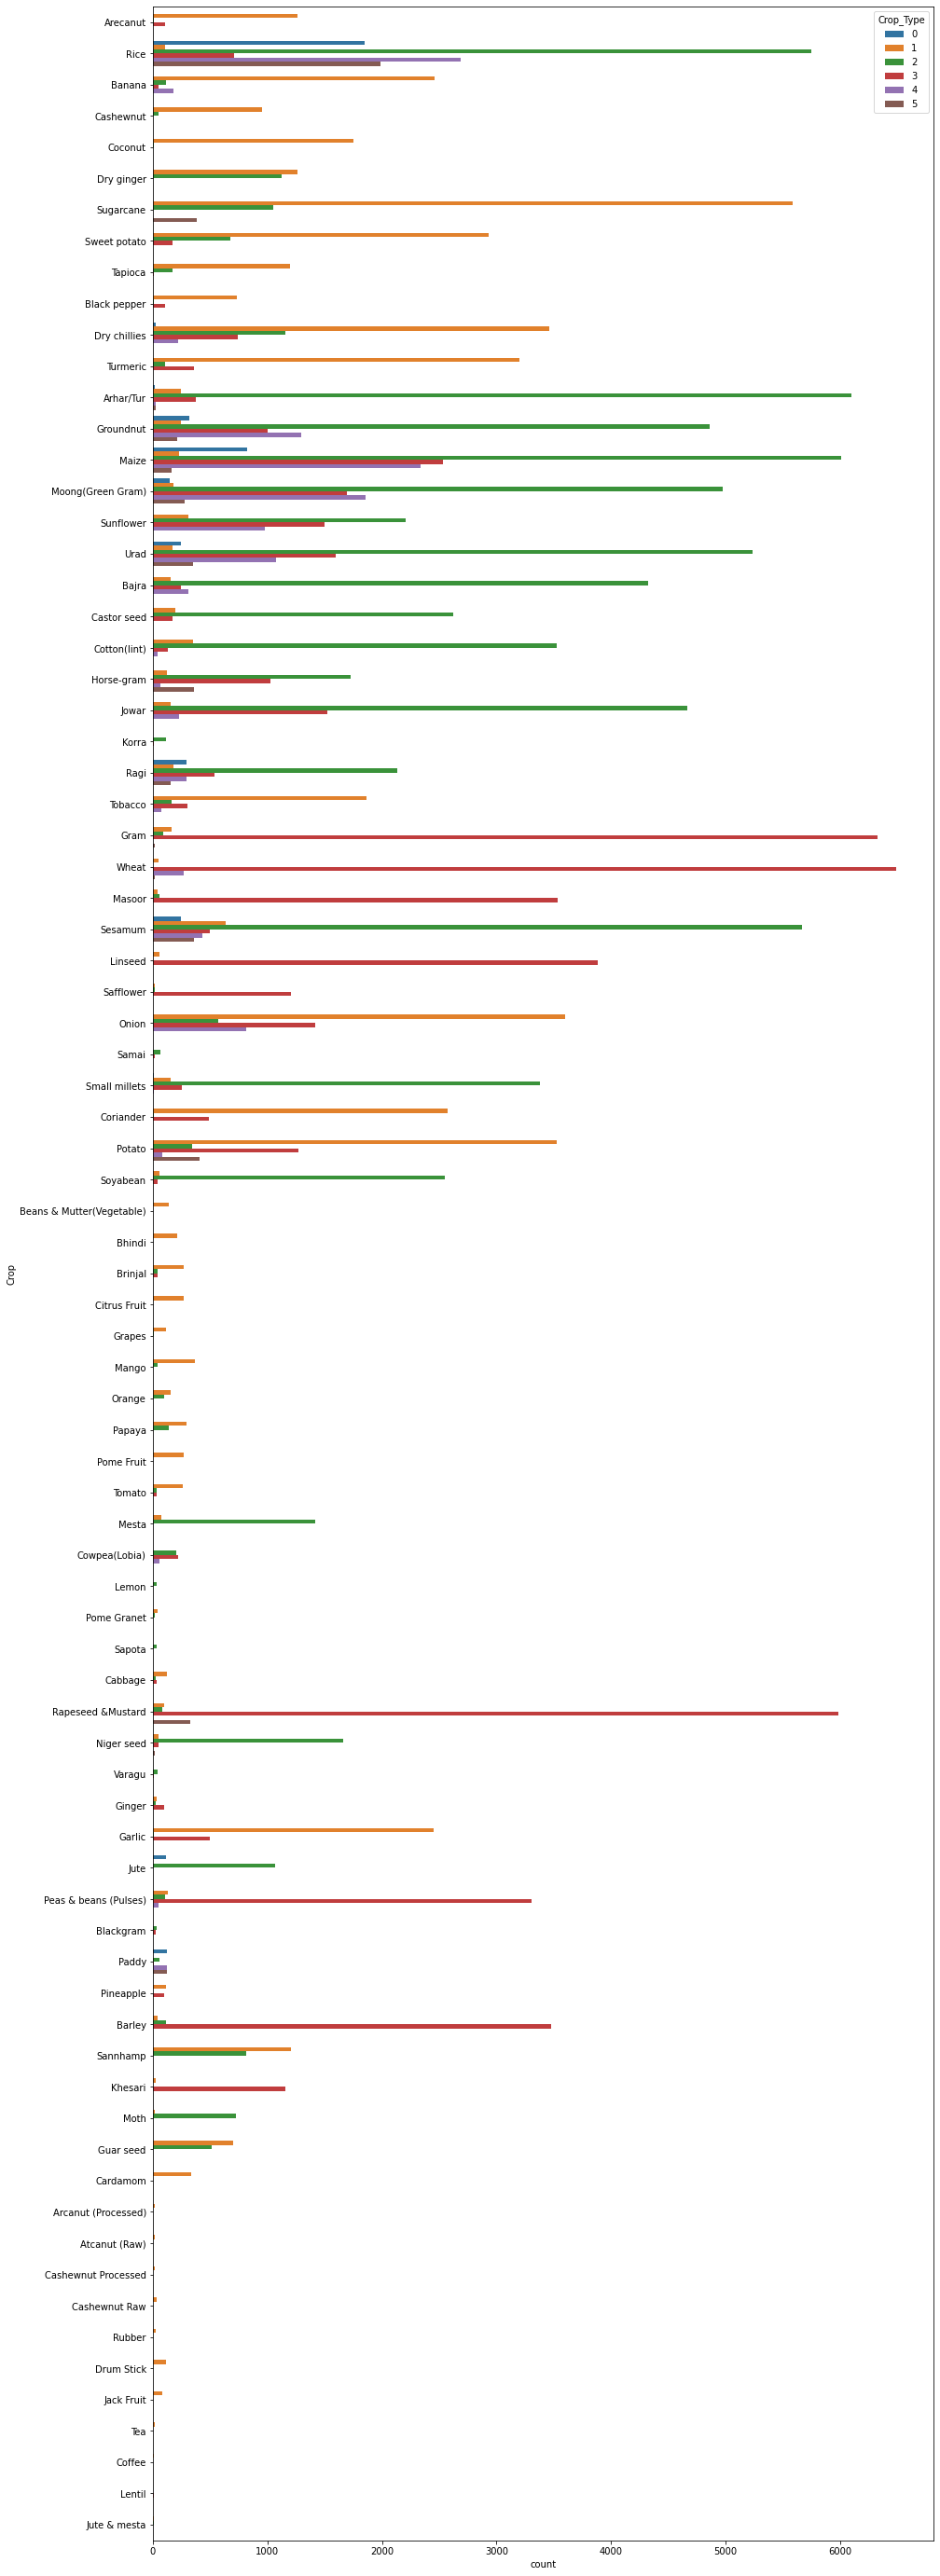

In [19]:
plt.figure(figsize=(15,50))
sns.countplot(y='Crop', data=df, hue='Crop_Type')

<AxesSubplot:xlabel='Crop_Type', ylabel='count'>

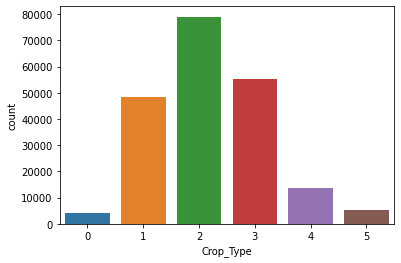

In [20]:
sns.countplot(x='Crop_Type', data=df)

In [21]:
pd.options.display.max_rows = None
df.groupby('Crop')['Crop_Type'].unique()

Crop
Arcanut (Processed)                         [1]
Arecanut                              [2, 1, 3]
Arhar/Tur                    [3, 2, 5, 1, 0, 4]
Atcanut (Raw)                               [1]
Bajra                              [2, 3, 1, 4]
Banana                          [1, 3, 5, 2, 4]
Barley                                [3, 2, 1]
Beans & Mutter(Vegetable)                   [1]
Bhindi                                      [1]
Black pepper                          [1, 3, 2]
Blackgram                                [3, 2]
Brinjal                            [1, 2, 3, 4]
Cabbage                               [2, 3, 1]
Cardamom                                 [1, 2]
Cashewnut                             [1, 3, 2]
Cashewnut Processed                         [1]
Cashewnut Raw                               [1]
Castor seed                           [2, 3, 1]
Citrus Fruit                                [1]
Coconut                                  [1, 2]
Coffee                             

## Analysis excluding 'Other...' crops

In [22]:
# Re-cluster after removing crops named as 'Other...'

other_crops = [crop for crop in df['Crop'].unique() if 'other' in crop.lower()]
other_crops

[]

In [23]:
df_v2 = df.loc[~df['Crop'].isin(other_crops)]
df_crop_v2 = pd.get_dummies(df_v2[['Crop', 'Season']].drop_duplicates())

In [24]:
silhouette_scores = []
inertia_scores = []
k_range = range(2, 20)
for k in k_range:
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(df_crop_v2)
    preds = clusterer.predict(df_crop_v2)
    centers = clusterer.cluster_centers_
    inertia_scores.append(clusterer.inertia_)
    silhouette_scores.append(silhouette_score(df_crop_v2, preds))

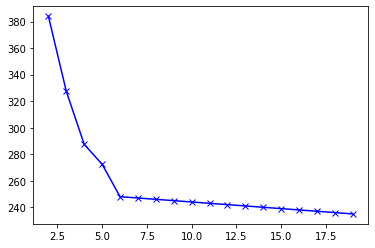

In [25]:
# Inertia vs k
plt.plot(k_range, inertia_scores, 'bx-')

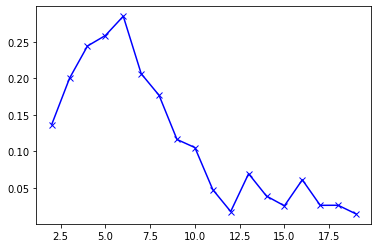

In [26]:
# Inertia vs k
plt.plot(k_range, silhouette_scores, 'bx-')

In [27]:
df_v2['Crop'].nunique()

81

In [28]:
df_v2['Season'].nunique()

6

In [29]:
df_v2_grouped = df_v2.groupby('Crop')['Season']

# Unique combinations of seasons based on crops
df_v2_grouped.unique().apply(lambda l: str(sorted(to_only_whole_year(l)))).unique()

array(["['Whole Year']", "['Kharif', 'Rabi']",
       "['Kharif', 'Rabi', 'Summer']", "['Autumn', 'Kharif', 'Rabi']",
       "['Kharif']", "['Rabi']"], dtype=object)

There are 6 unique combinations of farming seasons when other crops are excluded. This may be represented by six clusters.

In [30]:
clusterer_6 = KMeans(n_clusters=6)
clusterer_6.fit(df_crop_v2)
df_v2['Crop_Type'] = clusterer_6.predict(pd.get_dummies(df_v2[['Crop', 'Season']]))

<AxesSubplot:xlabel='count', ylabel='Crop'>

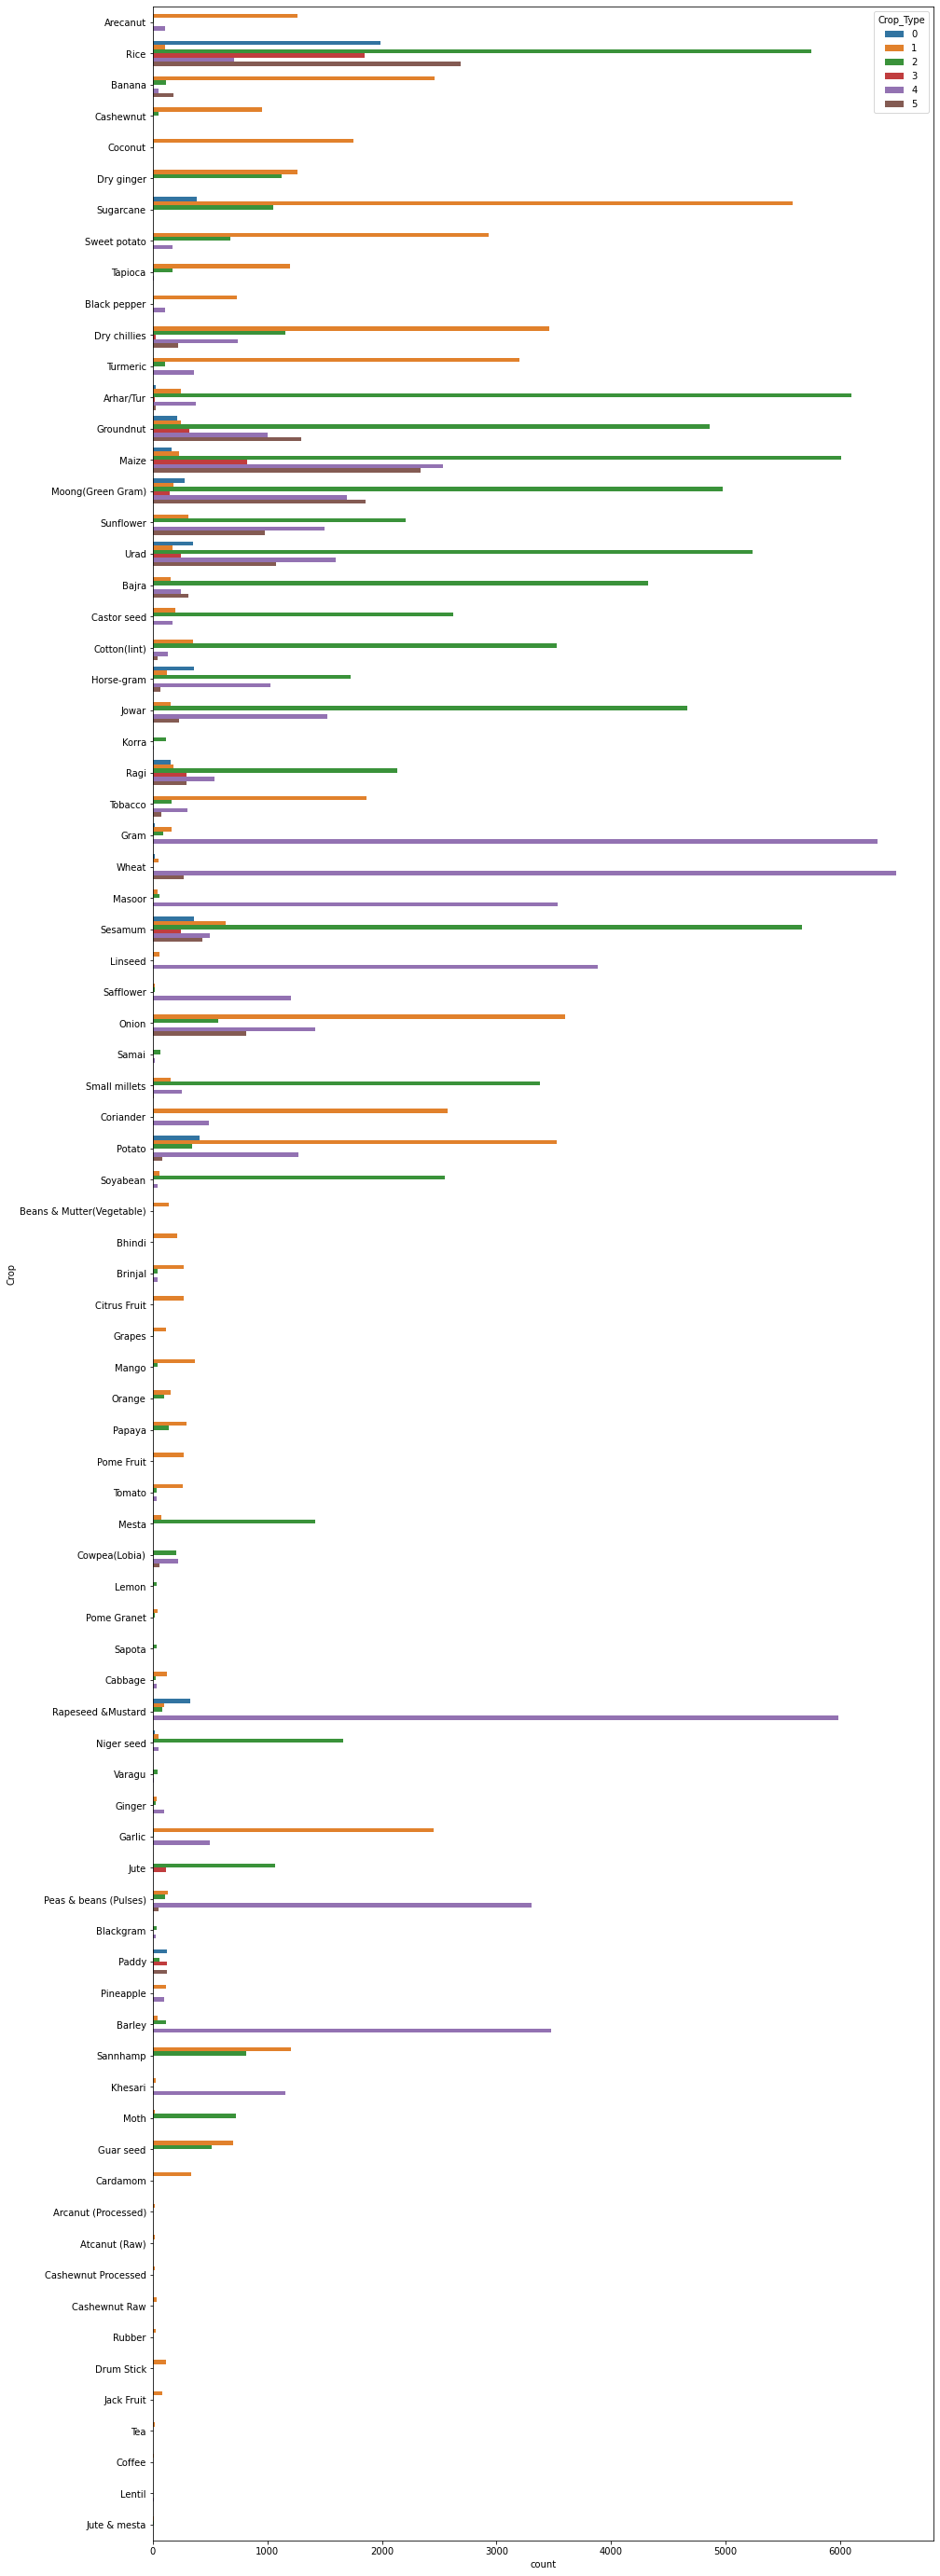

In [31]:
plt.figure(figsize=(15,50))
sns.countplot(y='Crop', data=df_v2, hue='Crop_Type')

<AxesSubplot:xlabel='Crop_Type', ylabel='count'>

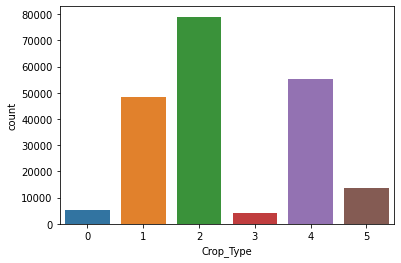

In [32]:
sns.countplot(x='Crop_Type', data=df_v2)

In [33]:
df_v2.loc[df_v2['Crop_Type'] == 5]['Crop'].unique()

array(['Rice', 'Paddy', 'Maize', 'Moong(Green Gram)', 'Bajra',
       'Groundnut', 'Sesamum', 'Urad', 'Onion', 'Sunflower', 'Jowar',
       'Peas & beans (Pulses)', 'Potato', 'Ragi', 'Dry chillies',
       'Cowpea(Lobia)', 'Cotton(lint)', 'Arhar/Tur', 'Wheat',
       'Horse-gram', 'Brinjal', 'Tobacco', 'Banana', 'Small millets'],
      dtype=object)

In [34]:
import pickle

In [35]:
with open('./crop_season_clusterer_6.pkl', 'wb') as f:
    pickle.dump(clusterer_6, f)